# Wikipedia Talk Data - Getting Started

This notebook gives an introduction to working with the various data sets in [Wikipedia
Talk](https://figshare.com/projects/Wikipedia_Talk/16731) project on Figshare. The release includes:

1. a large historical corpus of discussion comments on Wikipedia talk pages
2. a sample of over 100k comments with human labels for whether the comment contains a personal attack
3. a sample of over 100k comments with human labels for whether the comment has aggressive tone

Please refer to our [wiki](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release) for documentation of the schema of each data set and our [research paper](https://arxiv.org/abs/1610.08914) for documentation on the data collection and modeling methodology. 

In this notebook we show how to build a simple classifier for detecting personal attacks and apply the classifier to a random sample of the comment corpus to see whether discussions on user pages have more personal attacks than discussion on article pages.

## Building a classifier for personal attacks
In this section we will train a simple bag-of-words classifier for personal attacks using the [Wikipedia Talk Labels: Personal Attacks]() data set.

In [34]:
import pandas as pd
import urllib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

In [5]:
# download annotated comments and annotations

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 


def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

AttributeError: 'module' object has no attribute 'request'

In [14]:
comments = pd.read_csv('dataset/attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('dataset/attack_annotations.tsv',  sep = '\t')

In [3]:
len(annotations['rev_id'].unique())

115864

In [6]:
annotations[:3]

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0


In [7]:
comments[:3]

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train


In [15]:
# labels a comment as an atack if the majority of annoatators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

In [16]:
labels[:3]

rev_id
37675    False
44816    False
49851    False
Name: attack, dtype: bool

In [17]:
# join labels and comments
comments['attack'] = labels

In [9]:
comments[:3]

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train,False
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train,False
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train,False


In [18]:
# remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [19]:
comments[:3]

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,`- This is not ``creative``. Those are the di...,2002,False,article,random,train,False
44816,` :: the term ``standard model`` is itself le...,2002,False,article,random,train,False
49851,"True or false, the situation as of March 200...",2002,False,article,random,train,False


In [20]:
# query with boolean expression
comments.query('attack')['comment'].head()

rev_id
801279             Iraq is not good  ===  ===  USA is bad   
2702703      ____ fuck off you little asshole. If you wan...
4632658         i have a dick, its bigger than yours! hahaha
6545332      == renault ==  you sad little bpy for drivin...
6545351      == renault ==  you sad little bo for driving...
Name: comment, dtype: object

In [30]:
# fit a simple text classifier

train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', LogisticRegression()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.957


In [31]:
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', MultinomialNB()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.936


In [33]:
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', RandomForestClassifier()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.905


In [35]:
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', SVC()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

KeyboardInterrupt: 

In [38]:
# train_comments[:3]
test_comments[:3]

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
155243,:If I may butt in I've spent the last 1/4 h...,2002,True,user,random,test,False
177310,On my you will find the apology that I owe...,2002,True,user,random,test,False
286174,"Yep, that's Twin cities from which this ar...",2002,True,article,random,test,False


In [ ]:
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', MLPClassifier()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
auc = roc_auc_score(test_comments['attack'], clf.predict_proba(test_comments['comment'])[:, 1])
print('Test ROC AUC: %.3f' %auc)

In [22]:
# correctly classify nice comment
clf.predict(['Thanks for you contribution, you did a great job!'])

array([False], dtype=bool)

In [23]:
# correctly classify nasty comment
clf.predict(['People as stupid as you should not edit Wikipedia!'])

array([ True], dtype=bool)

## Prevalence of personal attacks by namespace
In this section we use our classifier in conjunction with the [Wikipedia Talk Corpus](https://figshare.com/articles/Wikipedia_Talk_Corpus/4264973) to see if personal attacks are more common on user talk or article talk page discussions. In our paper we show that the model is not biased by namespace.

In [2]:
import os
import re
import requests
from scipy.stats import bernoulli
% matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import tarfile

In [20]:
# download and untar data

USER_TALK_CORPUS_2004_URL = 'https://ndownloader.figshare.com/files/6982061'
ARTICLE_TALK_CORPUS_2004_URL = 'https://ndownloader.figshare.com/files/7038050'

USER_TALK_CORPUS_2004_r = requests.get(USER_TALK_CORPUS_2004_URL, allow_redirects=True)
ARTICLE_TALK_CORPUS_2004_r = requests.get(ARTICLE_TALK_CORPUS_2004_URL, allow_redirects=True)

open('dataset/comments_user_2004.tar.gz', 'wb').write(USER_TALK_CORPUS_2004_r.content)
open('dataset/comments_article_2004.tar.gz', 'wb').write(ARTICLE_TALK_CORPUS_2004_r.content)

# download_file(USER_TALK_CORPUS_2004_URL, 'dataset/comments_user_2004.tar.gz')
# download_file(ARTICLE_TALK_CORPUS_2004_URL,  'dataset/comments_article_2004.tar.gz')


# os.system('tar -xzf comments_user_2004.tar.gz')
# os.system('tar -xzf comments_article_2004.tar.gz')

for fname in os.listdir('dataset/'):
    if (fname.endswith(".tar.gz")):
        fname = 'dataset/' + fname
        tar = tarfile.open(fname, "r:gz")
        tar.extractall()
        tar.close()

256

In [1]:
# helper for collecting a sample of comments for a given ns and year from 
def load_no_bot_no_admin(ns, year, prob = 0.1):
    dfs = []
    
    data_dir = "dataset/comments_%s_%d" % (ns, year)
    for _, _, filenames in os.walk(data_dir):
        for filename in filenames:
            if re.match("chunk_\d*.tsv", filename):
                df = pd.read_csv(os.path.join(data_dir, filename), sep = "\t")
                df['include'] = bernoulli.rvs(prob, size=df.shape[0])
                df = df.query("bot == 0 and admin == 0 and include == 1")
                dfs.append(df)
                
    sample = pd.concat(dfs)
    sample['ns'] = ns
    sample['year'] = year
    
    return sample

In [5]:
df = pd.read_csv('dataset/comments_user_2004/chunk_0.tsv', sep = "\t")

In [6]:
df[:3]

,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_id,user_text,bot,admin
0,27831492,NEWLINENEWLINE==Picture of the day==NEWLINENEW...,NEWLINENEWLINE==Picture of the day==NEWLINENEW...,2004-07-23T18:51:06Z,3117954,Stevertigo/Archive 8,8551.0,Angela,0,0
1,16052837,"""NEWLINENEWLINE== Article Licensing ==NEWLINEN...","""NEWLINENEWLINE== Article Licensing ==NEWLINEN...",2004-12-10T23:27:38Z,13024795,GTBacchus,6120.0,Rambot,1,0
2,8510010,"""NEWLINENEWLINE== Article Licensing ==NEWLINEN...","""NEWLINENEWLINE== Article Licensing ==NEWLINEN...",2004-12-10T22:20:43Z,19503347,Tobias Conradi,6120.0,Rambot,1,0


In [7]:
df['include'] = bernoulli.rvs(0.1, size=df.shape[0])

In [8]:
df[:3]

,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_id,user_text,bot,admin,include
0,27831492,NEWLINENEWLINE==Picture of the day==NEWLINENEW...,NEWLINENEWLINE==Picture of the day==NEWLINENEW...,2004-07-23T18:51:06Z,3117954,Stevertigo/Archive 8,8551.0,Angela,0,0,0
1,16052837,"""NEWLINENEWLINE== Article Licensing ==NEWLINEN...","""NEWLINENEWLINE== Article Licensing ==NEWLINEN...",2004-12-10T23:27:38Z,13024795,GTBacchus,6120.0,Rambot,1,0,0
2,8510010,"""NEWLINENEWLINE== Article Licensing ==NEWLINEN...","""NEWLINENEWLINE== Article Licensing ==NEWLINEN...",2004-12-10T22:20:43Z,19503347,Tobias Conradi,6120.0,Rambot,1,0,0


In [9]:
# collect a random sample of comments from 2004 for each namespace
corpus_user = load_no_bot_no_admin('user', 2004)
corpus_article = load_no_bot_no_admin('article', 2004)
corpus = pd.concat([corpus_user, corpus_article])

In [10]:
corpus[:5]

,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_id,user_text,bot,admin,include,ns,year
12,7576593,"NEWLINENEWLINE:::I'll do the pigeon too, shoul...","NEWLINENEWLINE:::I'll do the pigeon too, shoul...",2004-11-17T12:01:13Z,2234204,Quadell,7872.0,Jimfbleak,0,0,1,user,2004
17,4505380,... [update: I also altered your German welco...,... [update: I also altered your German welco...,2004-06-26T01:08:00Z,9776909,JCarriker,81997.0,Paullisa,0,0,1,user,2004
21,2150361,NEWLINENEWLINE* Thanks for the quick response....,NEWLINENEWLINE* Thanks for the quick response....,2004-01-13T02:18:45Z,12651862,WhisperToMe,7643.0,DavidWBrooks,0,0,1,user,2004
41,2637824,NEWLINENEWLINEI think Michael should be tolera...,NEWLINE----NEWLINEI think Michael should be to...,2004-03-05T06:06:43Z,32997197,Michael,48540.0,Jesus Chirst,0,0,1,user,2004
42,5441606,NEWLINENEWLINEThe track times added to Hollywo...,NEWLINENEWLINEThe track times added to [[Holly...,2004-08-25T20:38:35Z,32997228,Mike Garcia,47960.0,Guanaco,0,0,1,user,2004


In [12]:
# Apply model
corpus['comment'] = corpus['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
corpus['comment'] = corpus['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [13]:
corpus[:3]

,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_id,user_text,bot,admin,include,ns,year
12,7576593,"NEWLINENEWLINE:::I'll do the pigeon too, shoul...","NEWLINENEWLINE:::I'll do the pigeon too, shoul...",2004-11-17T12:01:13Z,2234204,Quadell,7872.0,Jimfbleak,0,0,1,user,2004
17,4505380,... [update: I also altered your German welco...,... [update: I also altered your German welco...,2004-06-26T01:08:00Z,9776909,JCarriker,81997.0,Paullisa,0,0,1,user,2004
21,2150361,NEWLINENEWLINE* Thanks for the quick response....,NEWLINENEWLINE* Thanks for the quick response....,2004-01-13T02:18:45Z,12651862,WhisperToMe,7643.0,DavidWBrooks,0,0,1,user,2004


In [24]:
corpus['attack'] = clf.predict_proba(corpus['comment'])[:,1] > 0.425 # see paper

In [26]:
corpus[:3]

,rev_id,comment,raw_comment,timestamp,page_id,page_title,user_id,user_text,bot,admin,include,ns,year,attack
12,7576593,"NEWLINENEWLINE:::I'll do the pigeon too, shoul...","NEWLINENEWLINE:::I'll do the pigeon too, shoul...",2004-11-17T12:01:13Z,2234204,Quadell,7872.0,Jimfbleak,0,0,1,user,2004,False
17,4505380,... [update: I also altered your German welco...,... [update: I also altered your German welco...,2004-06-26T01:08:00Z,9776909,JCarriker,81997.0,Paullisa,0,0,1,user,2004,False
21,2150361,NEWLINENEWLINE* Thanks for the quick response....,NEWLINENEWLINE* Thanks for the quick response....,2004-01-13T02:18:45Z,12651862,WhisperToMe,7643.0,DavidWBrooks,0,0,1,user,2004,False


Text(0.5,0,u'Dicussion namespace')

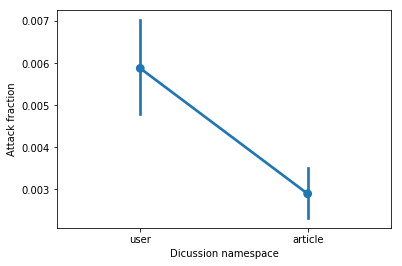

In [27]:
# plot prevalence per ns

sns.pointplot(data = corpus, x = 'ns', y = 'attack')
plt.ylabel("Attack fraction")
plt.xlabel("Dicussion namespace")

Attacks are far more prevalent in the user talk namespace.